# Identifying Global Outliers

In this notebook, we will go through the process of identifying global outliers in our source dataset. Global outliers are data points that are significantly different from the rest of the data.

We will be using the [Isolation Forest algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest) for detecting outliers in our data. The Isolation Forest algorithm is an unsupervised learning algorithm that is based on the Decision Tree algorithm. This algorithm is effective for high-dimensional datasets and works by isolating outliers instead of profiling normal data points as is the case with One-Class SVM algorithm. It is particularly efficient for datasets with a mix of numerical and categorical features, as is the case with the dataset we are working with.

In [6]:
# dependencies
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# data
input_csv = "../data/customer_churn_unprocessed.csv"
# save CSV file without outliers
output_csv = "../data/customer_churn_no_outliers.csv"

## Data Preprocessing

Before we can continue with outlier detection, we need to prepare our source data for it to be processed by the outlier detection algorithm.

For this, we will do the following:

1. Load the unprocessed source data.
2. Remove unwanted columns. These are the columns which have no significance in churn prediction, such as `customerID`. We will also drop the target column `Churn` as we are only interested in the features.
3. Encode categorical columns. We will use one-hot encoding to convert categorical columns into numerical columns.
4. Standardize the data. We will use the `StandardScaler` from `sklearn` to standardize the data.

In [7]:
# load data
df = pd.read_csv(input_csv)

# obtain the features dataset by dropping unwanted columns
X = df.drop(columns=["RowNumber", "CustomerId", "Surname", "Exited"])

# encode the categorical features - Geography, Gender and Card Type
encoder = LabelEncoder()
X["Geography"] = encoder.fit_transform(X["Geography"])
X["Gender"] = encoder.fit_transform(X["Gender"])
X["Card Type"] = encoder.fit_transform(X["Card Type"])

# standardize the feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# display first few rows of processed features
X.head(8)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Card Type,Point Earned
0,619,0,0,42,2,0.00,1,1,1,101348.88,1,2,0,464
1,608,2,0,41,1,83807.86,1,0,1,112542.58,1,3,0,456
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1,3,0,377
3,699,0,0,39,1,0.00,2,0,0,93826.63,0,5,1,350
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0,5,1,425
5,645,2,1,44,8,113755.78,2,1,0,149756.71,1,5,0,484
6,822,0,1,50,7,0.00,2,1,1,10062.80,0,2,3,206
7,376,1,0,29,4,115046.74,4,1,0,119346.88,1,2,0,282


## Outlier Detection

Now that we have preprocessed our data, we can move on to the outlier detection process.

For this, we will define and train an [Isolation Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest) model on our preprocessed data.

Most of the hyperparameters of the Isolation Forest model are set to their default values. The hyperparameters that we will be tuning are:

- `contamination`: The proportion of outliers in the data set. This is used when fitting to define the threshold on the decision function. For our dataset, we will set this to 0.1, as we expect no more than 10% of the data to be outliers. Setting this value any higher, will result in more data points being classified as outliers and as a result will lead to a drastic reduction in the size of training dataset available for the churn prediction model after outliers removal.
- `n_jobs`: The number of jobs to run in parallel for both `fit` and `predict`. We will set this to -1 to use all available CPU cores.
- `random_state`: The seed used by the random number generator. We will set this to 0 for reproducibility.

In [8]:
# instantiate and train the Isolation Forest model
iso_forest = IsolationForest(contamination=0.1, n_jobs=-1, random_state=0)
model = iso_forest.fit(X_scaled)

# predict outliers
outliers = model.predict(X_scaled)

# identify the outliers
outlier_indices = outliers == -1
outlier_data = X[outlier_indices]

# print number of outliers
print(f"Number of outliers: {outlier_data.shape[0]}")

# display first few outliers
outlier_data.head()

Number of outliers: 1000


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Card Type,Point Earned
1,608,2,0,41,1,83807.86,1,0,1,112542.58,1,3,0,456
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1,3,0,377
7,376,1,0,29,4,115046.74,4,1,0,119346.88,1,2,0,282
30,591,2,0,39,3,0.00,3,1,0,140469.38,1,3,0,298
35,475,0,0,45,0,134264.04,1,1,0,27822.99,1,1,0,877


## Evaluation

Let's now evaluate the performance and accuracy of the Isolation Forest model by verifying that some of the identifed outliers are indeed outliers. 

Before we do that though, let's first visually inspect and confirm data points identified as outliers by the Isolation Forest model.

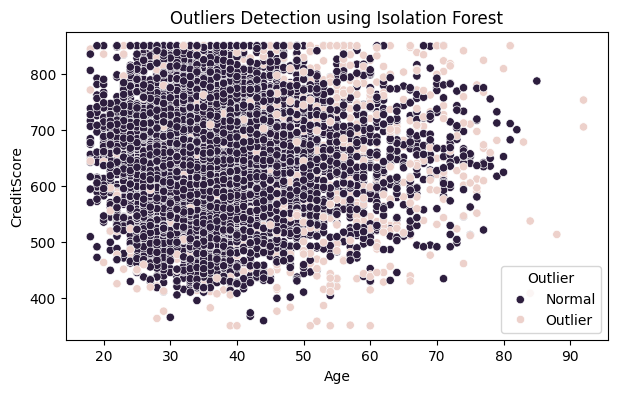

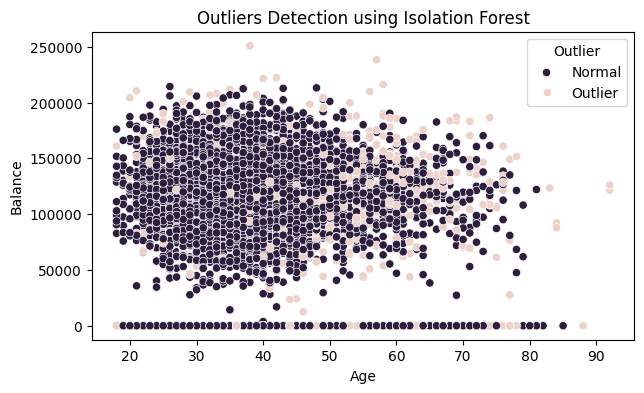

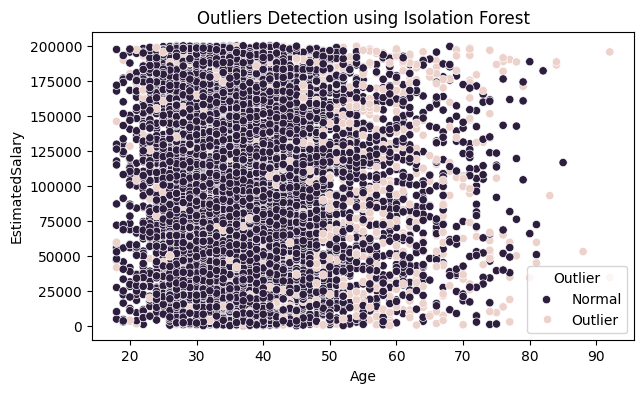

In [9]:
# visualize the outliers in a scatter plot

# create a scatter plot
def plot_outliers(x_label, y_label):
  plt.figure(figsize=(7, 4))
  sns.scatterplot(x=x_label, y=y_label, data=X, hue=outliers)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title("Outliers Detection using Isolation Forest")
  plt.legend(title="Outlier", labels=["Normal", "Outlier"])
  plt.show()

# we will plot outliers with Age as base column against three other features - CreditScore, Balance and EstimatedSalary
plot_outliers("Age", "CreditScore")
plot_outliers("Age", "Balance")
plot_outliers("Age", "EstimatedSalary")

As can be observed from above, our outlier detection algorithm did indeed identify most of the outliers, at least when examined based on the features above.

We can also visually compare the data distribution of features in source data and the outliers identified by the Isolation Forest model. This will help us understand the distribution of the outliers in the feature space.

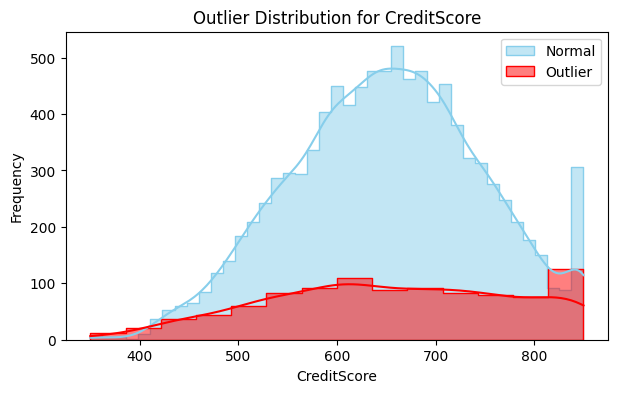

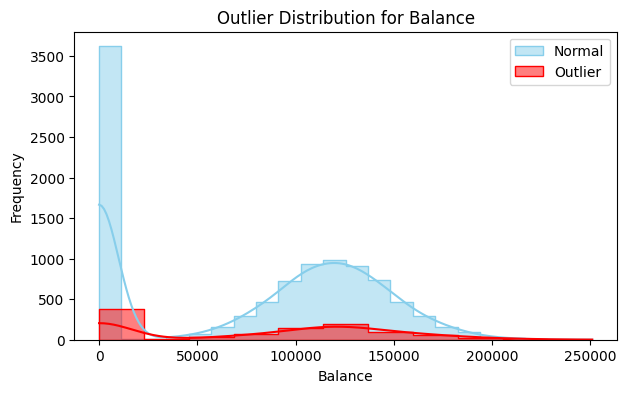

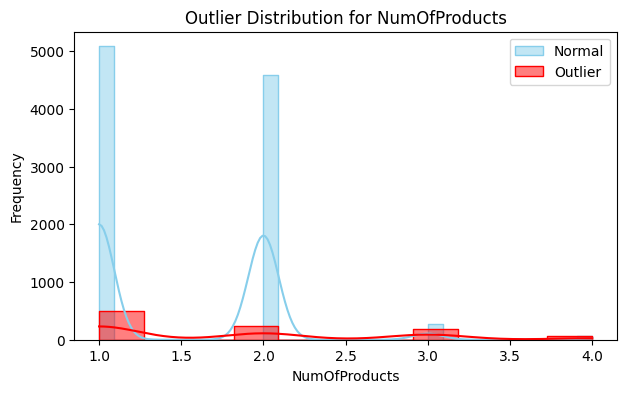

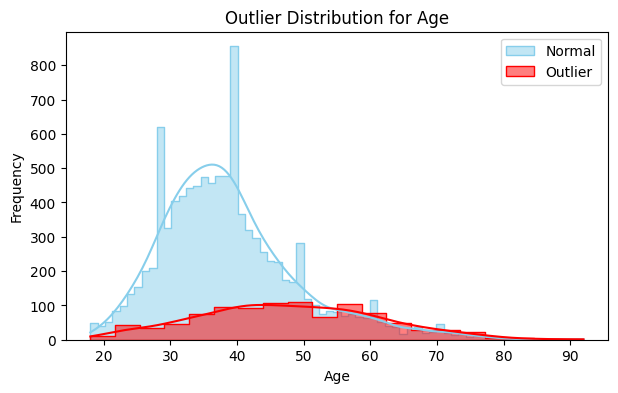

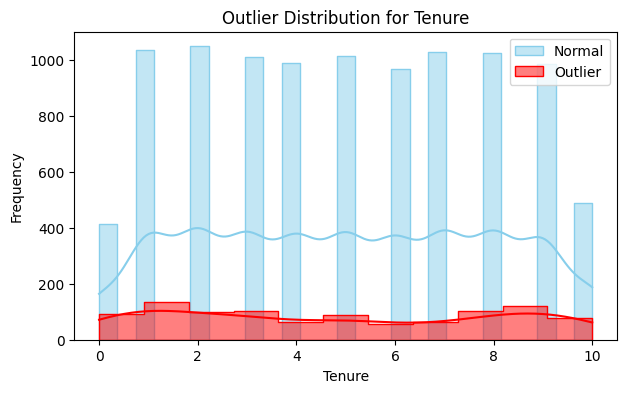

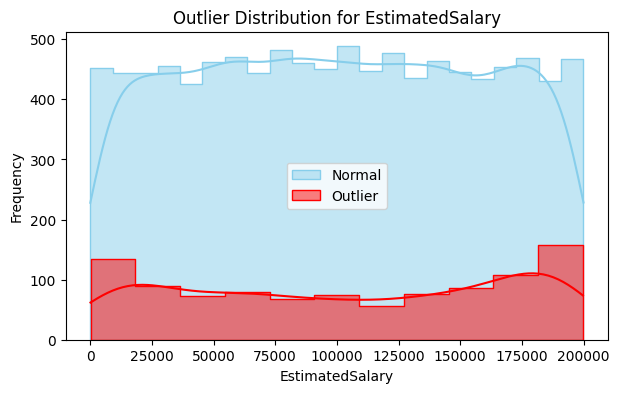

In [10]:
# plot distribution of outliers

# create a function to plot the distribution of outliers
def plot_outlier_distribution(feature):
  plt.figure(figsize=(7, 4))
  sns.histplot(data=df, x=feature, kde=True, color="skyblue", label="Normal", element="step")
  sns.histplot(data=outlier_data, x=feature, kde=True, color="red", label="Outlier", element="step")
  plt.xlabel(feature)
  plt.ylabel("Frequency")
  plt.title(f"Outlier Distribution for {feature}")
  plt.legend()
  plt.show()

# plot the distribution of outliers for relevant customer attributes
plot_outlier_distribution("CreditScore")
plot_outlier_distribution("Balance")
plot_outlier_distribution("NumOfProducts")
plot_outlier_distribution("Age")
plot_outlier_distribution("Tenure")
plot_outlier_distribution("EstimatedSalary")

Lets now confirm the outliers by examining the first few records identified as outliers by the Isolation Forest model.

In [11]:
# display the first few outliers
outlier_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Complain,Satisfaction Score,Card Type,Point Earned
1,608,2,0,41,1,83807.86,1,0,1,112542.58,1,3,0,456
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1,3,0,377
7,376,1,0,29,4,115046.74,4,1,0,119346.88,1,2,0,282
30,591,2,0,39,3,0.00,3,1,0,140469.38,1,3,0,298
35,475,0,0,45,0,134264.04,1,1,0,27822.99,1,1,0,877


Let's also print a statistical summary of the source dataset so we can compare the values given in the above table.

In [12]:
# statistical summary of the source data
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203800,0.204400,3.013800,606.515100
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402842,0.403283,1.405919,225.924839
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,1.000000,119.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,2.000000,410.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,0.000000,3.000000,605.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,0.000000,4.000000,801.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,5.000000,1000.000000


Analysis of each of the records above:

- 1: For the first customer, it is not clear why this record has been identified as an outlier. Customer's tenure is much lower than the average and the balance is also below the median bank balance, but apart from that other features seems to have values close to their respective average values. This might be a false positive.
- 2: Customer's balance is more than at least 80% of the customers in the dataset, credit score is below average and the number of products is 3 which is rare among the customers. This is a valid outlier.
- 3: Customer's credit score is much lower than the average credit score of the customers in the dataset. This is a valid outlier.
- 4: Customer has a high salary but the balance is 0. This might be a valid outlier.
- 5: Customer's has been less than 1 years with the bank, which is rare among the customers. This is a valid outlier.

## Results

We have successfully identified global outliers in our source dataset using the Isolation Forest algorithm. We have also visually inspected and confirmed that the identified outliers are indeed outliers.

For our final step, we will remove the outliers from the source data and save this new cleaned source data in a new CSV file. This new CSV file could be used for training the churn prediction model.

In [13]:
# remove outliers from the source data
df_no_outliers = df.drop(index=outlier_data.index)
# save the data without outliers
df_no_outliers.to_csv(output_csv, index=False)